# Self-driving car Nanodegree - Term 1
## Project 1: **Build a Traffic Sign Recognition Classifier**
***
In this project, we will use deep neural networks and convolutional neural networks to classify traffic signs. We will train and validate a model so it can classify traffic sign images using the German Traffic Sign Dataset as sample dataset.

Author : [Tran Ly Vu](https://github.com/tranlyvu)

- [Github repo](https://github.com/tranlyvu/autonomous-vehicle-projects/tree/master/Traffic%20Sign%20Classifier)
- [Notebook](https://github.com/tranlyvu/autonomous-vehicle-projects/blob/master/Traffic%20Sign%20Classifier/notebook/Traffic_Sign_Classifier.ipynb)
- [Python code](https://github.com/tranlyvu/autonomous-vehicle-projects/blob/master/Traffic%20Sign%20Classifier/src/second_attempt.py)

### Load and Visualize The DataSet

#### Sample Dataset Information

The [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) consists of 43 different traffic signs with each image having 32×32 px size. This dataset has 39,209 images as training data (Using this number of an image we have to train a neural network) and 12,630 images as a test data. Each image is a photo of one of the 43 class of traffic sign

Specifically , we will use the following [pickled dataset](https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip) provided by Udacity in which the images were resized to 32x32. The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

#### Importing packages

In [1]:
# Load pickled data
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline
import cv2
import glob
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

#### Loading data

In [2]:
def loaded_pickled_data(file):
    with open(file, mode='rb') as f:
        output = pickle.load(f)      
    return output

training_file = '../../../train.p'
validation_file= '../../../valid.p'
testing_file = '../../../test.p'

train = loaded_pickled_data(training_file)
valid = loaded_pickled_data(validation_file)
test = loaded_pickled_data(testing_file)
    
X_train_original, y_train_original = train['features'], train['labels']
X_valid_original, y_valid_original = valid['features'], valid['labels']
X_test_original, y_test_original = test['features'], test['labels']

assert(len(X_train_original) == len(y_train_original))
assert(len(X_valid_original) == len(y_valid_original))
assert(len(X_test_original) == len(y_test_original))


# number of training examples
n_train = len(X_train_original)

# Number of validation examples
n_validation = len(X_valid_original)

# Number of testing examples.
n_test = len(X_test_original)

# What's the shape of an traffic sign image?
image_shape = X_train_original.shape[1:]


# there are few ways to print tuple
print('Original training dataset shape is: {}'.format(X_train_original.shape))
print('Original validation dataset shape is: ', X_valid_original.shape)
print('Original test dataset shape is: ', X_test_original.shape)
print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of test examples =", n_test)
print("Image data shape =", image_shape)

Original training dataset shape is: (34799, 32, 32, 3)
Original validation dataset shape is:  (4410, 32, 32, 3)
Original test dataset shape is:  (12630, 32, 32, 3)
Number of training examples = 34799
Number of validation examples = 4410
Number of test examples = 12630
Image data shape = (32, 32, 3)


#### Include an exploratory visualization of the dataset

Number of classes = 43
Class 0: Speed limit (20km/h)                               180 samples
Class 1: Speed limit (30km/h)                               1980 samples
Class 2: Speed limit (50km/h)                               2010 samples
Class 3: Speed limit (60km/h)                               1260 samples
Class 4: Speed limit (70km/h)                               1770 samples
Class 5: Speed limit (80km/h)                               1650 samples
Class 6: End of speed limit (80km/h)                        360 samples
Class 7: Speed limit (100km/h)                              1290 samples
Class 8: Speed limit (120km/h)                              1260 samples
Class 9: No passing                                         1320 samples
Class 10: No passing for vehicles over 3.5 metric tons       1800 samples
Class 11: Right-of-way at the next intersection              1170 samples
Class 12: Priority road                                      1890 samples
Class 13: Yield            

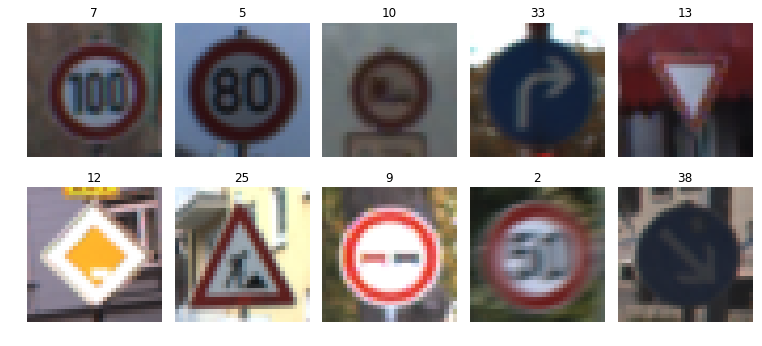

In [3]:
"""plotting 10 randome traffic sign images"""
def plot_10_random_images(features, labels):
    fig, axes = plt.subplots(2, 5, figsize=(13, 6))
    fig.subplots_adjust(left=None, right=None, hspace = .02, wspace=0.1)
    for i in range(2):
        for j in range(5):
            randomindex = random.randint(0, len(features) - 1) 
            axes[i,j].axis('off')
            axes[i,j].imshow(features[randomindex])
            axes[i,j].set_title(labels[randomindex])

            
# How many unique classes/labels there are in the dataset.
classes = pd.read_csv('../signnames.csv') 
print("Number of classes =", len(classes))

sign_names = classes.values[:,1]
# class_indices: position where class appear, class_counts: number of count of class
sign_classes, class_indices, class_counts = np.unique(y_train_original, return_index = True, return_counts = True)
# longest name of sign names
longest_sign_name = max(len(name) for name in sign_names)

for c, c_index, c_count in zip(sign_classes, class_indices, class_counts):
    print ("Class %i: %-*s %s samples" % (c, longest_sign_name, sign_names[c], str(c_count)))
      
plot_10_random_images(X_train_original, y_train_original)           

----

### Design and Train Classifier Model

#### Defining data pre-processing and model training functions

In [4]:
def grayscale(input_image):
    output = []
    for i in range(len(input_image)): 
        img = cv2.cvtColor(input_image[i], cv2.COLOR_RGB2GRAY)
        output.append(img) 
    return output

def normalization(input_image):
    """normalization
      Pre-defined interval [-1,1]
      from the forum :https://discussions.udacity.com/t/accuracy-is-not-going-over-75-80/314938/22 
      some said that using the decimal 128.0 makes huge diffference
    """
    output = []
    for i in range(len(input_image)): 
        img = np.array((input_image[i] - 128.0) / (128.0), dtype=np.float32)
        output.append(img) 
    return output

def get_weights(input_shape):
    return tf.Variable(tf.truncated_normal(shape = input_shape, mean = 0.0, stddev = 0.1))

def get_biases(length):
     return tf.Variable(tf.zeros(length))

#NOTE: number of filter is output channel  
def convolution_layer(input_image,
                      filter_size,
                      input_channel, 
                      number_of_filters,
                      padding_choice = 'VALID'):

    shape = [filter_size, filter_size, input_channel, number_of_filters]
    weights = get_weights(input_shape = shape)
    biases = get_biases(length = number_of_filters) 
    layer = tf.nn.conv2d(input = input_image, 
                         filter = weights, 
                         strides = [1, 1, 1, 1], 
                         padding = padding_choice) + biases
    return layer


def activation_relu(input_layer):
    return tf.nn.relu(input_layer)

def max_spooling(input_layer, padding_choice):
    return tf.nn.max_pool(value = input_layer,
                          ksize = [1, 2, 2, 1],
                          strides = [1, 2, 2, 1],
                         padding= padding_choice)

def flatten_layer(input_layer):        
    return flatten(input_layer)

def fully_connected_layer(input_layer,
                          number_of_inputs,
                          number_of_outputs):
    
    weights = get_weights(input_shape = [number_of_inputs, number_of_outputs])
    biases = get_biases(length = number_of_outputs) 
    layer = tf.matmul(input_layer, weights) + biases
    return layer

def dropout_layer(layer, keep_prob):
    layer = tf.nn.dropout(layer, keep_prob)
    return layer

#### [First attempt](https://github.com/tranlyvu/autonomous-vehicle-projects/blob/master/Traffic%20Sign%20Classifier/src/first_attempt.py)

My first attempt was to try the famous Lenet-5 model:

![lenet 5](../../img/lenet.png)


1. pre-processing pipeline
    - Graysclale 
    - Normalization
2. Model design:
    - The original Lenet-5 model
    
|Layer   |type    |Input   |output  |
|--------|--------|--------|--------|
|1       |conv    |32x32x1 |28x28x6 |
|        |relu    |        |        |
|        |max_pool|28x28x6 |14x14x6 |
|2       |conv    |14x14x6 |10x10x16|
|        |relu    |        |        |
|        |max_pool|10x10x16|5x5x16  |
|        |flatten |5x5x16  |400     |
|3       |linear  |400     |120     |
|        |relu    |        |        |
|4       |linear  |120     |84      |
|        |relu    |        |        |
|5       |linear  |84      |43      |

#### Second attempt

First attempt only gave me 86% vadilation accuracy with 28 epochs. Validation loss is way higher than training loss and they converge at different values. This is strong signal of overfitting.

There are few techniques to battle overfitting:
```
- Increase training dataset
- Regulazation, i.e dropout
- Reduce the complexity of training model
```    
The conplexity of original Lener-5 is pretty simple, so I chose to apply dropout to every layers of the model

Second attempt summary:
```
1. Pre-processing pipeline:
    - Grayscale
    - Normalization

2a. Model design:
    - Original Lenet-5 model with dopout of 0.5 to every layers
 
After running for 300 epochs, my validation accuracy reached 89% and there is no signal of overfitting. I decided to increase the complexity of model to improve the accuracy.

2b. Model re-design

|Layer   |type    |Input   |output  |
|--------|--------|--------|--------|
|1       |conv    |32x32x1 |28x28x10|
|        |relu    |        |        |
|        |dropout |        |        |
|2       |conv    |28x28x10|24x24x20|
|        |relu    |        |        |
|        |dropout |        |        |
|3       |conv    |24x24x10|20x20x30|
|        |relu    |        |        |
|        |dropout |        |        |
|4       |conv    |20x20x30|16x16x40|
|        |relu    |        |        |
|        |max_pool|16x16x40|8x8x40  |
|        |dropout |        |        |
|        |flatten |8x8x40  |2560    |
|5       |linear  |2560    |1280    |
|        |relu    |        |        |
|6       |linear  |1280    |640     |
|        |relu    |        |        |
|7       |linear  |640     |320     |
|        |relu    |        |        |
|8       |linear  |320     |160     |
|        |relu    |        |        |
|9       |linear  |160     |80      |
|        |relu    |        |        |
|10      |linear  |80      |43      |

```

#### Model definition

In [5]:
"""Pre-processing data"""
def preprocess_data(input_image):
    gray_image = grayscale(input_image)
    output =  normalization(gray_image)
    output = np.expand_dims(output, 3)
    return output

X_train_final = preprocess_data(X_train_original) 
X_valid_final = preprocess_data(X_valid_original)
print(X_train_final[0].shape)

"""Model design"""
def Lenet_5_model(input_image):    
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x10.
    conv1 = convolution_layer(input_image, 5, 1, 10, 'VALID')
    conv1 = activation_relu(conv1)
    
    # Layer 2: Convolutional. Input = 28x28x10. Output = 24x24x20.
    conv2 = convolution_layer(conv1, 5, 10, 20, 'VALID')
    conv2 = activation_relu(conv2)
    # drop-out
    conv2 = dropout_layer(conv2, keep_prob)
    
    # Layer 3: Convolutional. Input = 24x24x20. Output = 20x20x30.
    conv3 = convolution_layer(conv2, 5, 20, 30, 'VALID')
    conv3 = activation_relu(conv3)
    # drop-out
    conv3 = dropout_layer(conv3, keep_prob)
    
    # Layer 4: Convolutional. Input = 20x20x30. Output = 16x16x40.   
    conv4 = convolution_layer(conv3, 5, 30, 40, 'VALID')
    conv4 = tf.nn.relu(conv4)
    # max_pool: output = 8x8x40
    conv4 = max_spooling(conv4, 'VALID')
    # drop-out
    conv4 = dropout_layer(conv4, keep_prob)

    # Flatten. Input = 8x8x40. Output = 2560.
    fc0   = flatten_layer(conv4)        
    
    # Layer 5: Fully Connected. Input = 2560. Output = 1280.
    fc1 = fully_connected_layer(fc0, 2560, 1280)
    fc1 = tf.nn.relu(fc1)

    # Layer 6: Fully Connected. Input = 1280. Output = 640.
    fc2 = fully_connected_layer(fc1, 1280, 640)
    fc2 = tf.nn.relu(fc2)

    # Layer 7: Fully Connected. Input = 640. Output = 320 
    fc3 = fully_connected_layer(fc2, 640, 320)
    fc3 = tf.nn.relu(fc3)
    
    # Layer 8: Fully Connected. Input = 320. Output = 160 
    fc4 = fully_connected_layer(fc3, 320, 160)
    fc4 = tf.nn.relu(fc4)
    
    # Layer 9: Fully Connected. Input = 160. Output = 80 
    fc5 = fully_connected_layer(fc4, 160, 80)
    fc5 = tf.nn.relu(fc5)
    
    # Layer 10: Fully Connected. Input = 80. Output = 43 
    logits = fully_connected_layer(fc5, 80, 43)   
    
    return logits

"""Evaluation function"""
def evaluate(X_data, y_data, my_keep_prob):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset : offset + BATCH_SIZE], y_data[offset : offset + BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, 
                                                                                   y: batch_y, 
                                                                                   keep_prob: my_keep_prob})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_loss / num_examples, total_accuracy / num_examples 

(32, 32, 1)


#### Model training

In [6]:
"""Parameters setting"""
EPOCHS = 40
#EPOCHS = 1
BATCH_SIZE = 128
LEARNING_RATE = 0.0001

'''Training and save'''

keep_prob = tf.placeholder(tf.float32)
# x is a placeholder for a batch of input images. y is a placeholder for a batch of output labels.
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
# convert to 1 hot-coded data
one_hot_y = tf.one_hot(y, 43)

logits = Lenet_5_model(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

train_loss_history = []
valid_loss_history = []

Training...
EPOCH 1 ...
Training Accuracy = 0.091
Validation Accuracy = 0.071
Training Loss = 3.653
Validation Loss = 3.673
EPOCH 2 ...
Training Accuracy = 0.160
Validation Accuracy = 0.112
Training Loss = 3.499
Validation Loss = 3.548
EPOCH 3 ...
Training Accuracy = 0.332
Validation Accuracy = 0.268
Training Loss = 3.010
Validation Loss = 3.109
EPOCH 4 ...
Training Accuracy = 0.545
Validation Accuracy = 0.499
Training Loss = 1.861
Validation Loss = 1.983
EPOCH 5 ...
Training Accuracy = 0.686
Validation Accuracy = 0.639
Training Loss = 1.186
Validation Loss = 1.301
EPOCH 6 ...
Training Accuracy = 0.800
Validation Accuracy = 0.738
Training Loss = 0.765
Validation Loss = 0.883
EPOCH 7 ...
Training Accuracy = 0.838
Validation Accuracy = 0.790
Training Loss = 0.570
Validation Loss = 0.710
EPOCH 8 ...
Training Accuracy = 0.885
Validation Accuracy = 0.825
Training Loss = 0.431
Validation Loss = 0.575
EPOCH 9 ...
Training Accuracy = 0.916
Validation Accuracy = 0.861
Training Loss = 0.335
Vali

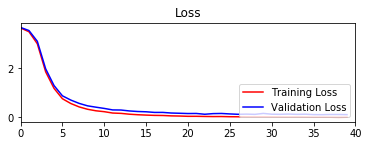

In [7]:
#Start running tensor flow
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_final)

    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train_final, y_train_original)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

        valid_loss, valid_accuracy = evaluate(X_valid_final, y_valid_original, 1.0)
        valid_loss_history.append(valid_loss)

        train_loss, train_accuracy = evaluate(X_train_final, y_train_original, 1.0)
        train_loss_history.append(train_loss)

        print("EPOCH {} ...".format(i + 1))
        print("Training Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(valid_accuracy))

        print("Training Loss = {:.3f}".format(train_loss))
        print("Validation Loss = {:.3f}".format(valid_loss))


    saver.save(sess, '../../../lenet')
    print("Model saved")
    loss_plot = plt.subplot(2,1,1)
    loss_plot.set_title('Loss')
    loss_plot.plot(train_loss_history, 'r', label='Training Loss')
    loss_plot.plot(valid_loss_history, 'b', label='Validation Loss')
    loss_plot.set_xlim([0, EPOCHS])
    loss_plot.legend(loc=4)

#### Model evaluation

In [8]:
X_test_final = preprocess_data(X_test_original) 
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('../../../lenet.meta')
    saver.restore(sess, '../../../lenet')
    test_loss, test_accuracy = evaluate(X_test_final, y_test_original, 1.0)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.946


---
### Test a Model on New Images

To give more insight into how the model is working, we will test pictures of German traffic signs taken from the web and use the  model to predict the traffic sign type. The file `../signnames.csv` contains mappings from the class id (integer) to the actual sign name.

#### Load and Output the Images

(5, 32, 32, 3)


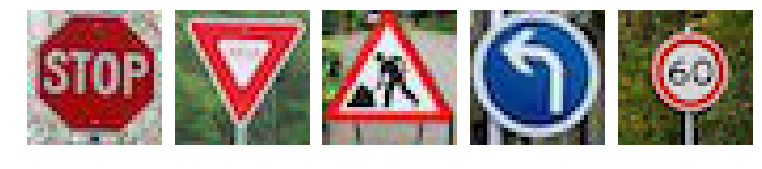

In [18]:
from numpy import newaxis
import os

TEST_IMAGES  =  os.listdir('../new_images')
fig, axes = plt.subplots(1, 5, figsize=(13, 6))
fig.subplots_adjust(left=None, right=None, hspace = .02, wspace=0.1)
sample_list = []

i = 0
for img in TEST_IMAGES:
    img = '../new_images/' + img
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    sample_list.append(img)
    axes[i].axis('off')
    axes[i].imshow(img)
    i += 1
    
print(np.shape(sample_list))

In [19]:
sample_list = preprocess_data(sample_list)
print(sample_list.shape)

(5, 32, 32, 1)


#### Analyze Performance of 5 test images

In [20]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
# img1: a 60 km/h sign,
# img2:  a left turn ahead sign
# img3: a road work sign
# img4: a stop sign 
# img5: a yield sign

image_labels = [14, 13, 25, 34, 3]

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('../../../lenet.meta')
    saver.restore(sess, '../../../lenet')
    test_loss, test_accuracy = evaluate(sample_list, image_labels, 1.0)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.200


#### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [22]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, '../../../lenet')
    classes = sess.run(logits, feed_dict={x: sample_list, keep_prob : 1.0})
    predicts = sess.run(tf.nn.top_k(classes, k=5, sorted=True))
    
for i in range(len(predicts[0])):
    print('Image', i, 'probabilities:', predicts[0][i], '\n and predicted classes:', predicts[1][i])

Image 0 probabilities: [ 13.9200325   10.72568226  10.35555363   7.58743      7.35433578] 
 and predicted classes: [25 26 14 38 22]
Image 1 probabilities: [ 19.96980286  10.44184303   9.51710796   8.9512825    8.69927692] 
 and predicted classes: [13 28 32  7 12]
Image 2 probabilities: [ 23.23275375  21.5736351   21.43789482  20.47696114  19.22176361] 
 and predicted classes: [18 11  1 40  6]
Image 3 probabilities: [ 16.24049377  14.39472675  13.68966866  12.65828323  11.32670689] 
 and predicted classes: [38 12 15 13 36]
Image 4 probabilities: [ 10.11780834   8.21930599   7.45331097   6.52531624   6.32419109] 
 and predicted classes: [10  9  5  2 16]


---

### Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")